In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # K折交叉验证模块
from sklearn.preprocessing import MinMaxScaler

import QUANTAXIS as QA
import pandas as pd
import numpy as np
import pyecharts
import talib

#设定绘图的默认大小
import matplotlib
matplotlib.rcParams["figure.figsize"]=[16,5]

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC','SimHei']
matplotlib.rcParams['axes.unicode_minus']=False #用来正常显示负号

#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set(font=['Noto Sans CJK SC','SimHei'])

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
stock_code='601398'
benchmark_code='399300'
start_time='2005-01-01'
end_time='2018-12-31'

In [7]:
data_raw=QA.QA_fetch_stock_day_adv(stock_code, start_time, end_time).to_qfq().data.reset_index().set_index('date')
data_raw.head(1)

,code,open,high,low,close,volume,amount,preclose,adj
date,,,,,,,,,
2006-10-27,601398,1.992133,2.01557,1.910104,1.921823,4.407654e+07,8.725310e+09,NaN,0.585922


In [8]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2943 entries, 2006-10-27 to 2018-12-28
Data columns (total 9 columns):
code        2943 non-null object
open        2943 non-null float64
high        2943 non-null float64
low         2943 non-null float64
close       2943 non-null float64
volume      2943 non-null float64
amount      2943 non-null float64
preclose    2942 non-null float64
adj         2943 non-null float64
dtypes: float64(8), object(1)
memory usage: 229.9+ KB


#### 日回报率

'median:0.0'

'mean:0.0005010841684081561'

'std:0.017735717542003725'

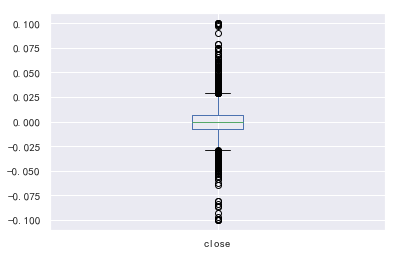

In [104]:
data=data_raw.copy()
close_pct_change=data['close'].pct_change()
# close_pct_change.describe()
close_pct_change.dropna().plot(kind='box')
'median:{}'.format(close_pct_change.median())
'mean:{}'.format(close_pct_change.mean())
'std:{}'.format(close_pct_change.std())

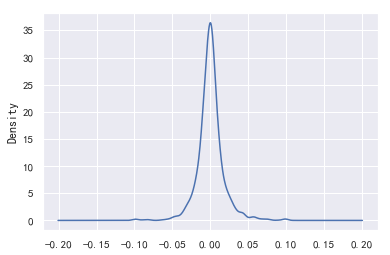

In [100]:
close_pct_change.dropna().plot(kind='kde')

##### volume,amount与close之间并无线性关系

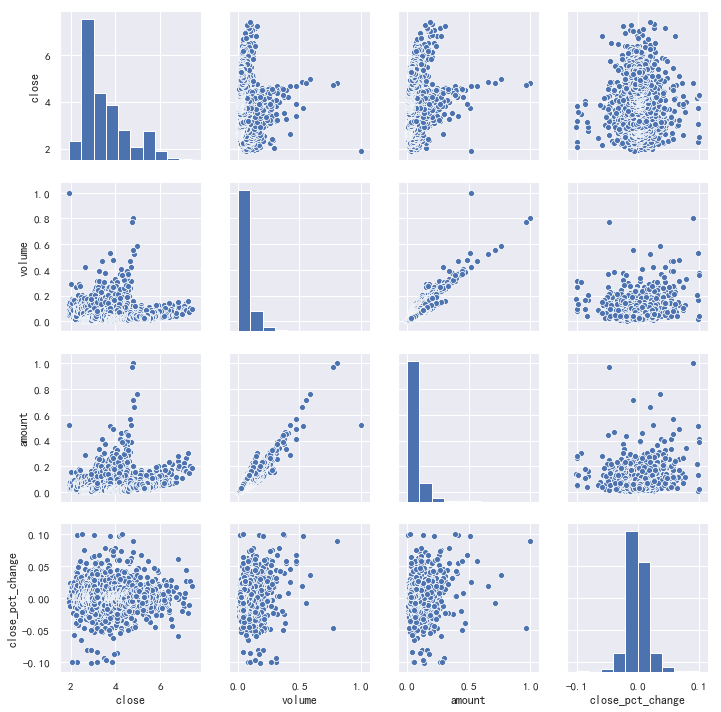

In [16]:
data=data_raw.copy()
data['close_pct_change']=data['close'].pct_change()
data[['volume','amount']]=MinMaxScaler().fit_transform(data[['volume','amount']])
sns.pairplot(data=data[['close','volume','amount','close_pct_change']])

#### Beta系数

https://zh.wikipedia.org/wiki/Beta%E7%B3%BB%E6%95%B0

　　贝塔系数（Beta Coefficient）是一种评估证券系统性风险的工具，用以度量一种证券或一个投资证券组合相对总体市场的波动性。在股票、基金等投资术语中常见。

　　贝塔系数是统计学上的概念，它所反映的是某一投资对象相对于大盘的表现情况。其绝对值越大，显示其收益变化幅度相对于大盘的变化幅度越大；绝对值越小，显示其变化幅度相对于大盘越小。如果是负值，则显示其变化的方向与大盘的变化方向相反；大盘涨的时候它跌，大盘跌的时候它涨。由于我们投资于投资基金的目的是为了取得专家理财的服务,以取得优于被动投资于大盘的表现情况，这一指标可以作为考察基金经理降低投资波动性风险的能力。 在计算贝塔系数时,除了基金的表现数据外,还需要有作为反映大盘表现的指标。
  
https://wiki.mbalib.com/wiki/%E8%B4%9D%E5%A1%94%E7%B3%BB%E6%95%B0

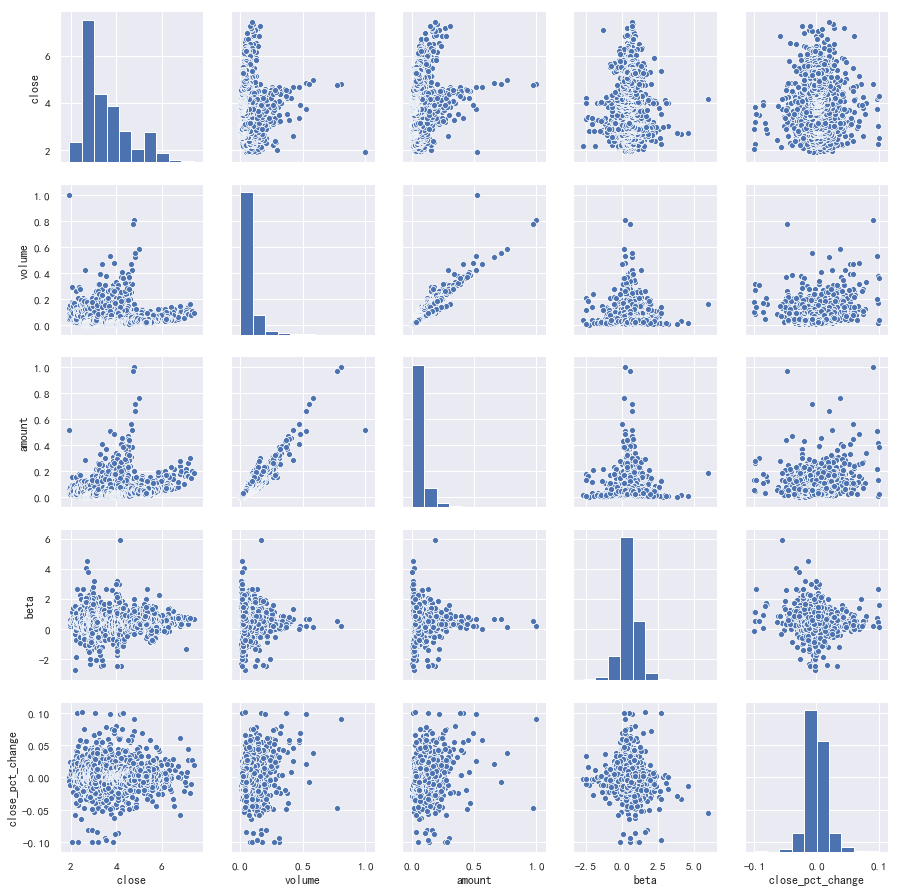

In [17]:
data['beta']=talib.BETA(np.array(data['high']), np.array(data['low']))
sns.pairplot(data=data[['close','volume','amount','beta','close_pct_change']])

#### 相对强弱指数（Relative Strength Index，RSI）

https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%B0%8D%E5%BC%B7%E5%BC%B1%E6%8C%87%E6%95%B8

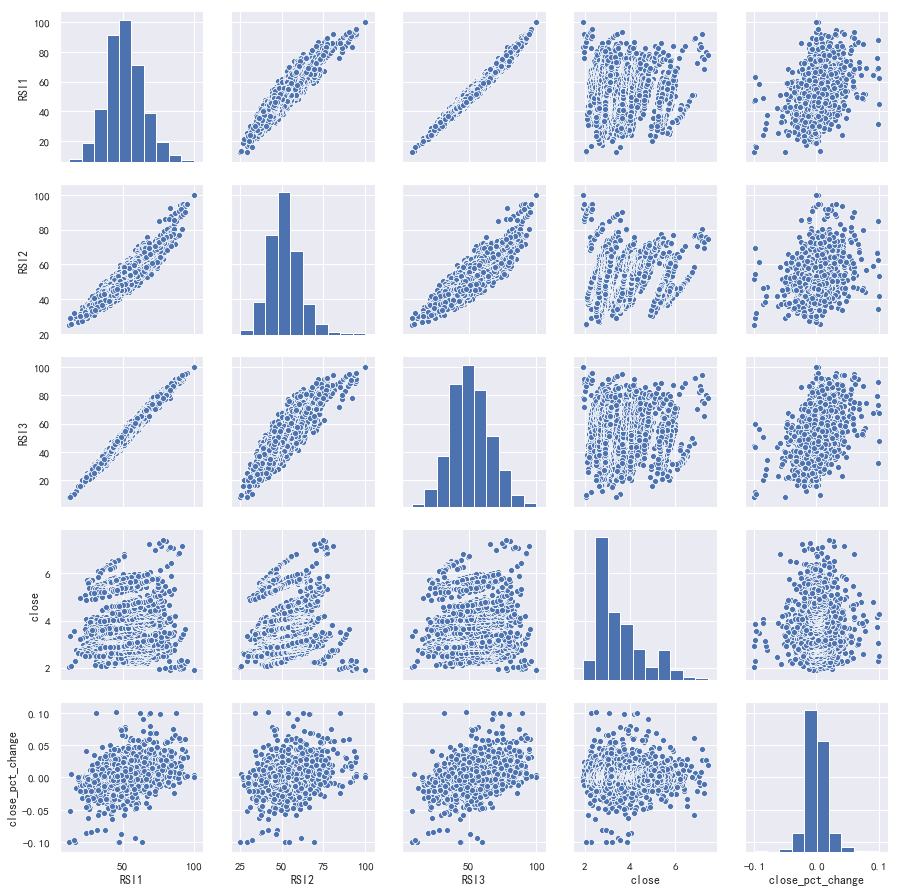

In [64]:
rsi=QA.QA_indicator_RSI(data).join(data[['close','close_pct_change']])
sns.pairplot(data=rsi)

In [68]:
rsi[['RSI1','RSI2','RSI3']]=MinMaxScaler().fit_transform(rsi[['RSI1','RSI2','RSI3']])
rsi['close_pct_change']=rsi['close_pct_change']*100
rsi.head()

,RSI1,RSI2,RSI3,close,close_pct_change
date,,,,,
2006-10-27,1.000000,1.000000,1.00000,1.921823,NaN
2006-10-30,1.000000,1.000000,1.00000,1.927682,0.304878
2006-10-31,1.000000,1.000000,1.00000,1.933541,0.303951
2006-11-01,1.000000,1.000000,1.00000,1.933541,0.000000
2006-11-02,0.811114,0.897415,0.76243,1.921823,-0.606061


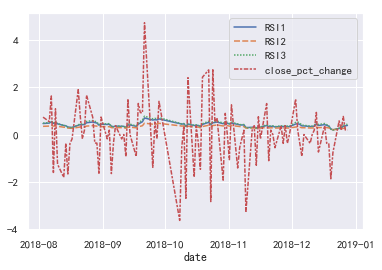

In [70]:
sns.lineplot(data=rsi[['RSI1','RSI2','RSI3','close_pct_change']].iloc[-100:])

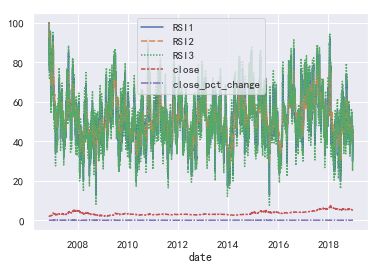

In [65]:
sns.lineplot(data=rsi)

#### 威廉指标 (%R)

https://zh.wikipedia.org/wiki/%E5%A8%81%E5%BB%89%E6%8C%87%E6%A8%99

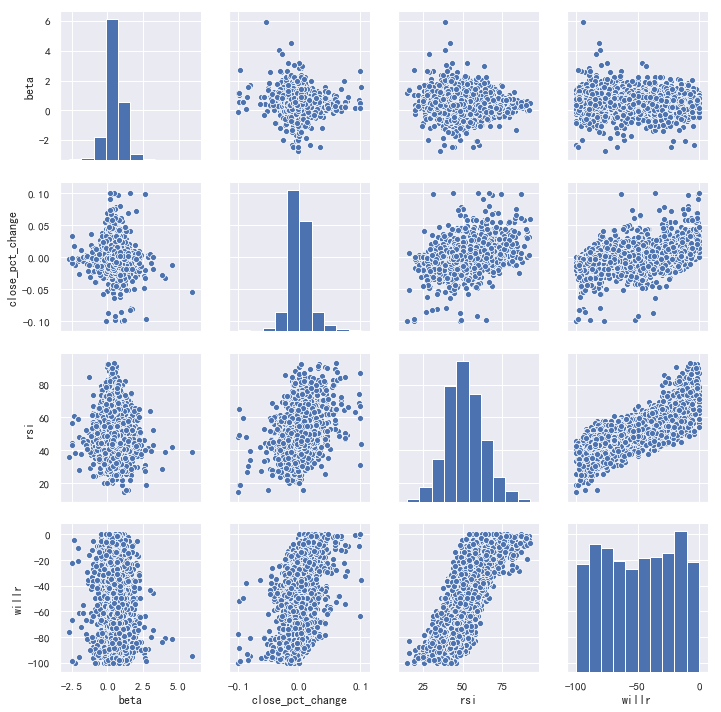

In [22]:
data['willr']=talib.WILLR(np.array(data['high']),np.array(data['low']),np.array(data['close']))
sns.pairplot(data=data[['beta','close_pct_change','rsi','willr']])

#### KDJ

In [72]:
kdj=QA.QA_indicator_KDJ(data).join(data[['close']])
# kdj=pd.DataFrame(MinMaxScaler().fit_transform(kdj),columns=kdj.columns,index=kdj.index).join(data[['close_pct_change']])

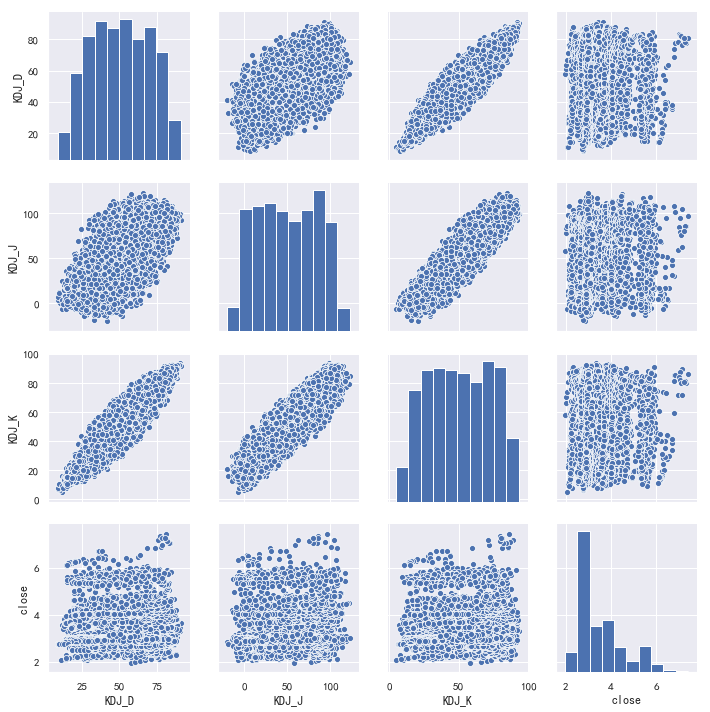

In [73]:
sns.pairplot(data=kdj)

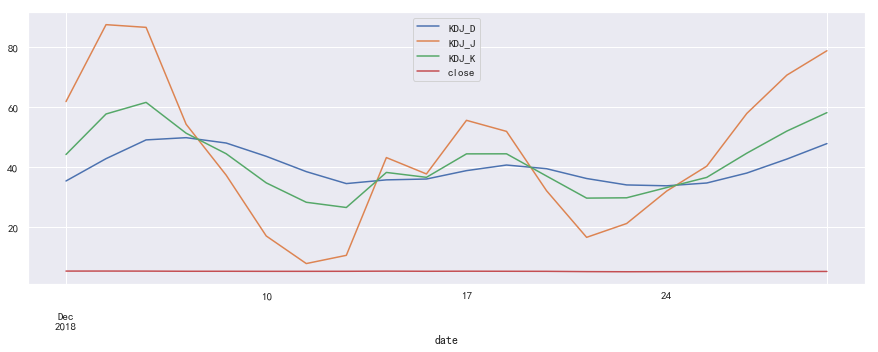

In [76]:
kdj[-20:].plot(figsize=(15,5))

#### 能量潮指标(OBV)

　　能量潮指标（On Balance Volume，OBV）是葛兰维（Joe Granville）于本世纪60年代提出的，并被广泛使用。股市技术分析的四大要素：价、量、时、空。OBV指标就是从“量”这个要素作为突破口，来发现热门股票、分析股价运动趋势的一种技术指标。它是将股市的人气——成交量与股价的关系数字化、直观化，以股市的成交量变化来衡量股市的推动力，从而研判股价的走势。关于成交量方面的研究，OBV能量潮指标是一种相当重要的分析指标之一。
  
https://wiki.mbalib.com/wiki/%E8%83%BD%E9%87%8F%E6%BD%AE%E6%8C%87%E6%A0%87

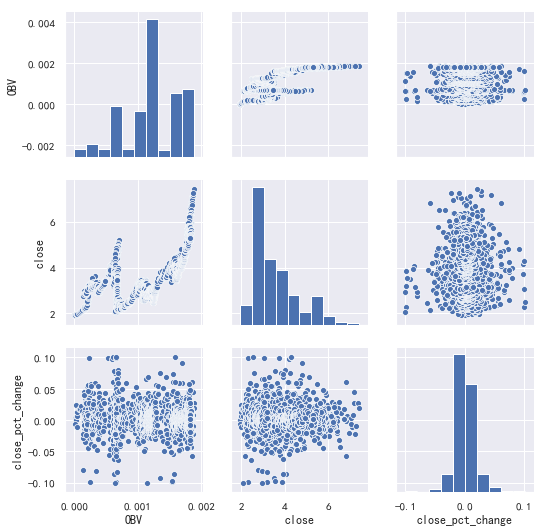

In [57]:
obv=QA.QA_indicator_OBV(data).join(data[['close','close_pct_change']])
sns.pairplot(data=obv)

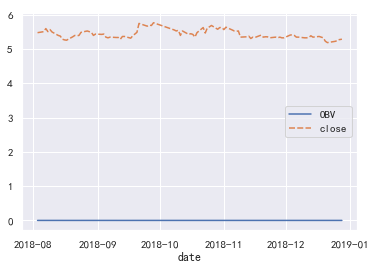

In [62]:
sns.lineplot(data=obv.iloc[-100:][['OBV','close']])